# MegaMedical multi-dataset embedding clustering

Load images from multiple MegaMedical tasks, embed with 5 encoders, then visualize PCA and k-means clustering.


In [1]:
# --- Imports ---
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Ensure repo and vendored deps are on path
repo_root = Path("/data/ddmg/mvseg-ordering/")
for path in [repo_root, repo_root / "UniverSeg", repo_root / "MultiverSeg"]:
    if str(path) not in sys.path:
        sys.path.append(str(path))

from experiments.dataset.mega_medical_dataset import MegaMedicalDataset
from experiments.encoders.multiverseg_encoder import MultiverSegEncoder
from experiments.encoders.clip import CLIPEncoder
from experiments.encoders.vit import ViTEncoder
from experiments.encoders.dinov2 import DinoV2Encoder
from experiments.encoders.medsam import MedSAMEncoder


In [2]:
# --- Config ---

# Pick device
device = torch.device('cpu')

# Use MegaMedical target indices for easy editing.
# Each entry is (target_index, n_samples).
# Edit indices + counts to control which datasets and how many images.
mega_targets = [
    (0, 3),
    (29, 3),
    (12, 4),
]

# Random seed (used for sampling within each target dataset)
seed = 23
np.random.seed(seed)
torch.manual_seed(seed)


In [3]:
# --- Load images across MegaMedical target indices ---

def load_target_images(target_index, n_samples, *, split='train', seed=23):
    ds = MegaMedicalDataset(dataset_target=target_index, split=split, seed=seed)
    indices = ds.get_data_indices()
    rng = np.random.default_rng(seed + int(target_index))
    if n_samples > len(indices):
        n_samples = len(indices)
    pick = rng.choice(indices, size=n_samples, replace=False).tolist()
    images = []
    for idx in pick:
        img, _ = ds.get_item_by_data_index(idx)
        images.append(img)
    return images, pick

all_images = []
all_labels = []
all_meta = []

for target_index, n_samples in mega_targets:
    imgs, indices = load_target_images(target_index, n_samples, seed=seed)
    all_images.extend(imgs)
    all_labels.extend([f"target_{target_index}"] * len(imgs))
    for idx in indices:
        all_meta.append({
            'mega_target_index': int(target_index),
            'index': int(idx),
        })

print(f"Loaded {len(all_images)} images across {len(mega_targets)} MegaMedical targets")


No updates to index
Filtered task_df: 1248
got task df: 1248


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


target_datasets: 1248
No updates to index


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


Filtered task_df: 1248
got task df: 1248
target_datasets: 1248
No updates to index


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


Filtered task_df: 1248
got task df: 1248
target_datasets: 1248
Loaded 10 images across 3 MegaMedical targets


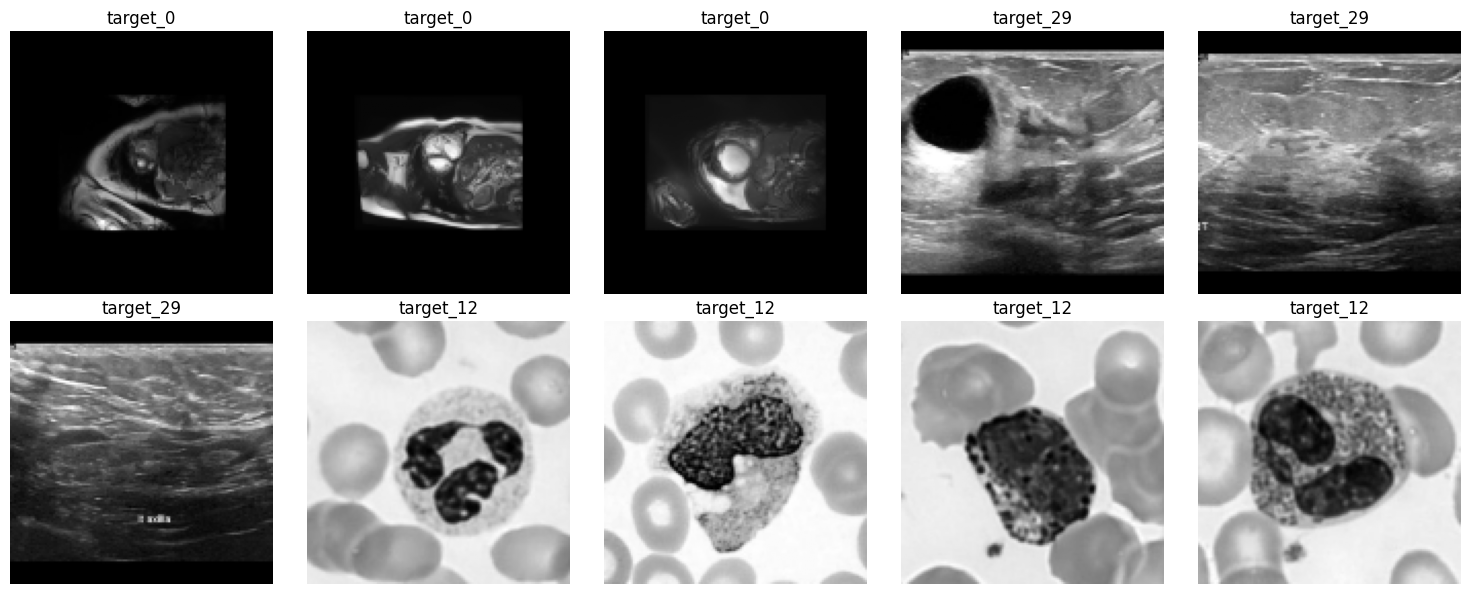

In [4]:
# --- Visualize selected images ---
n = len(all_images)
cols = min(5, n)
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(3 * cols, 3 * rows))
if rows == 1:
    axes = [axes] if cols == 1 else axes
axes_flat = axes if isinstance(axes, (list, tuple)) else axes.flatten()
for i in range(rows * cols):
    ax = axes_flat[i]
    if i < n:
        img = all_images[i].detach().cpu().squeeze().numpy()
        ax.imshow(img, cmap='gray')
        ax.set_title(all_labels[i])
    ax.axis('off')
fig.tight_layout()
plt.show()


In [5]:
# --- Build encoders ---
encoders = {
    'multiverseg': MultiverSegEncoder(pooling='gap_gmp'),
    'clip': CLIPEncoder(model_name='ViT-B-32', pretrained='openai'),
    'vit': ViTEncoder(model_name='vit_b_16', pretrained=True),
    'dinov2': DinoV2Encoder(model_name='facebook/dinov2-base'),
    'medsam': MedSAMEncoder(model_type='vit_b'),
}

for k in encoders:
    encoders[k] = encoders[k].to(device).eval()


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/data/ddmg/mvseg-ordering/experiments/encoders/medsam.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the

In [6]:
# --- Compute embeddings ---
@torch.no_grad()
def embed_images(encoder, images):
    embs = []
    for img in images:
        img = img.to(device)
        emb = encoder(img)
        if emb.dim() > 1:
            emb = emb.squeeze(0)
        embs.append(emb.detach().cpu().numpy())
    return np.stack(embs, axis=0)

embeddings = {name: embed_images(enc, all_images) for name, enc in encoders.items()}


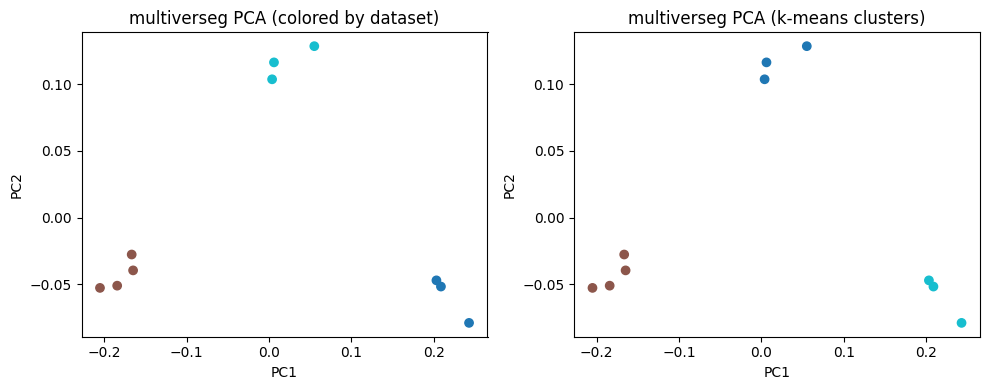

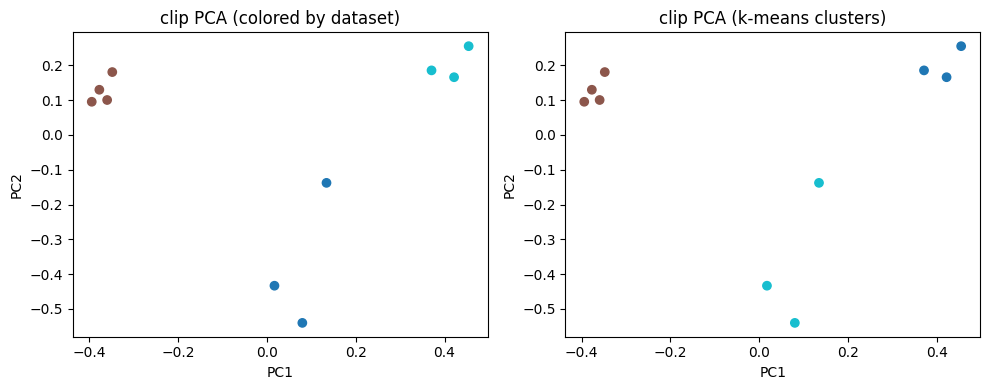

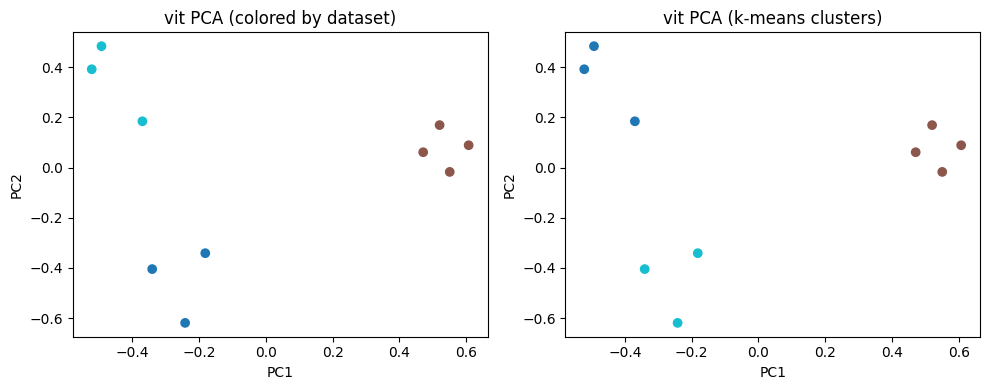

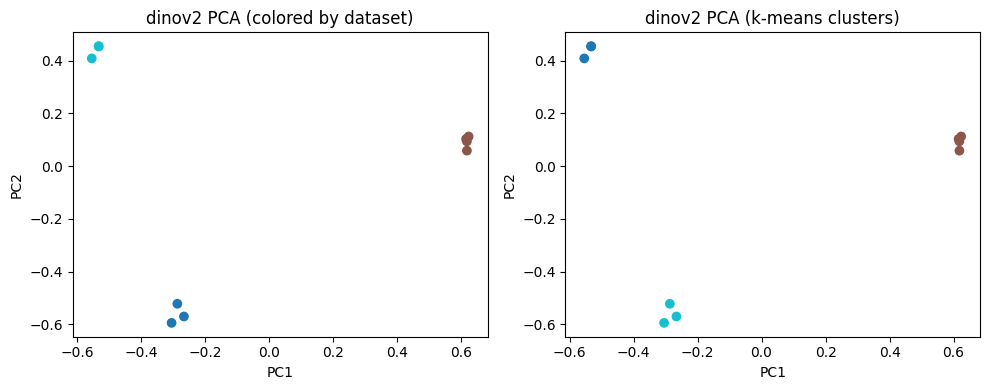

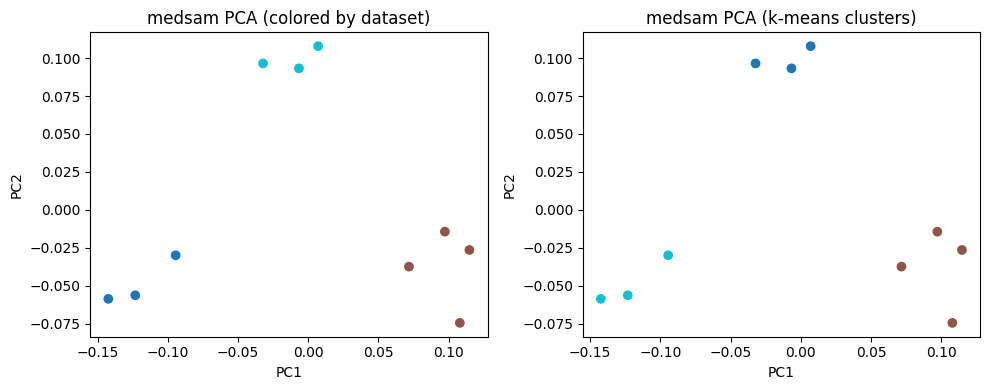

In [7]:
# --- PCA + KMeans visualization ---

label_names = sorted(set(all_labels))
label_to_id = {l: i for i, l in enumerate(label_names)}
colors = [label_to_id[l] for l in all_labels]

for name, emb in embeddings.items():
    pca = PCA(n_components=2, random_state=seed)
    emb2 = pca.fit_transform(emb)

    # k-means clustering (k = number of datasets)
    k = len(label_names)
    km = KMeans(n_clusters=k, random_state=seed, n_init='auto')
    clusters = km.fit_predict(emb2)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].scatter(emb2[:, 0], emb2[:, 1], c=colors, cmap='tab10')
    axes[0].set_title(f"{name} PCA (colored by dataset)")
    axes[1].scatter(emb2[:, 0], emb2[:, 1], c=clusters, cmap='tab10')
    axes[1].set_title(f"{name} PCA (k-means clusters)")
    for ax in axes:
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
    fig.tight_layout()
    plt.show()


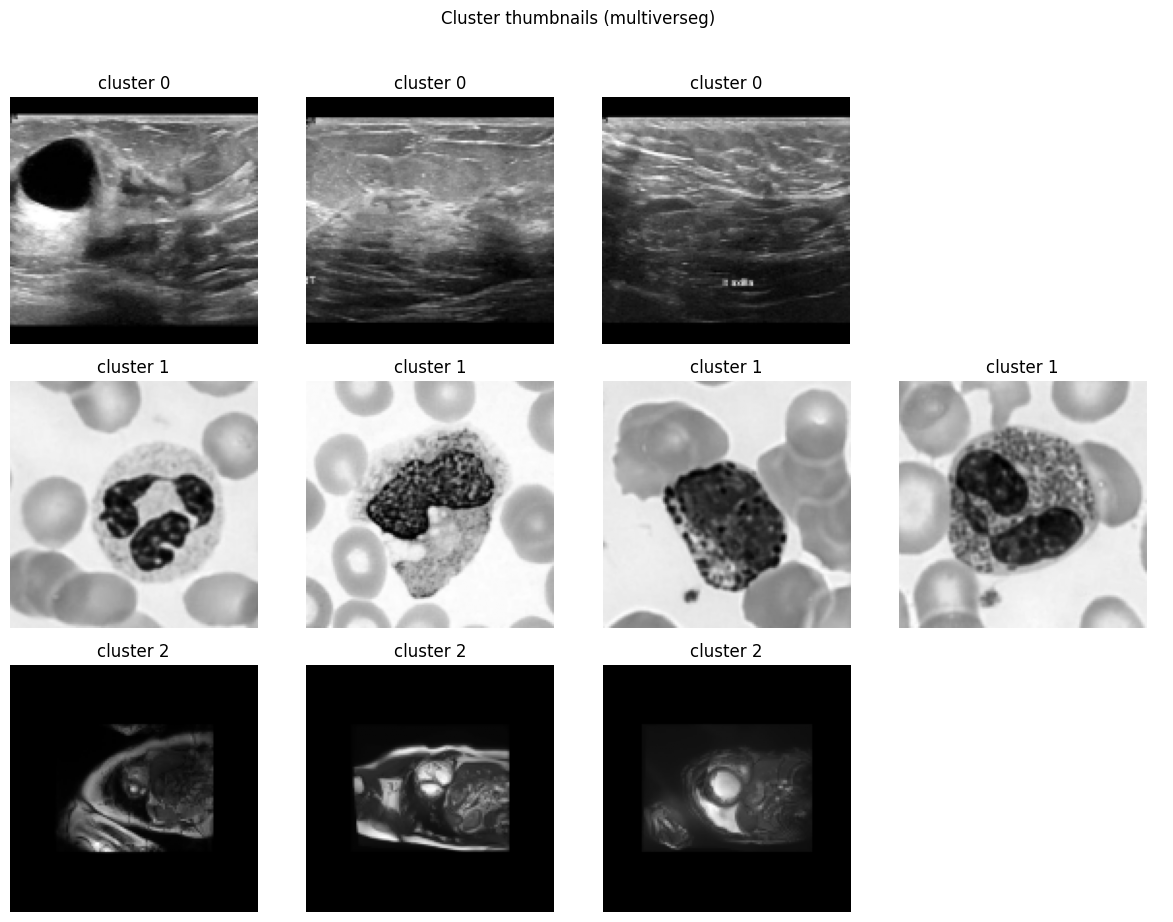

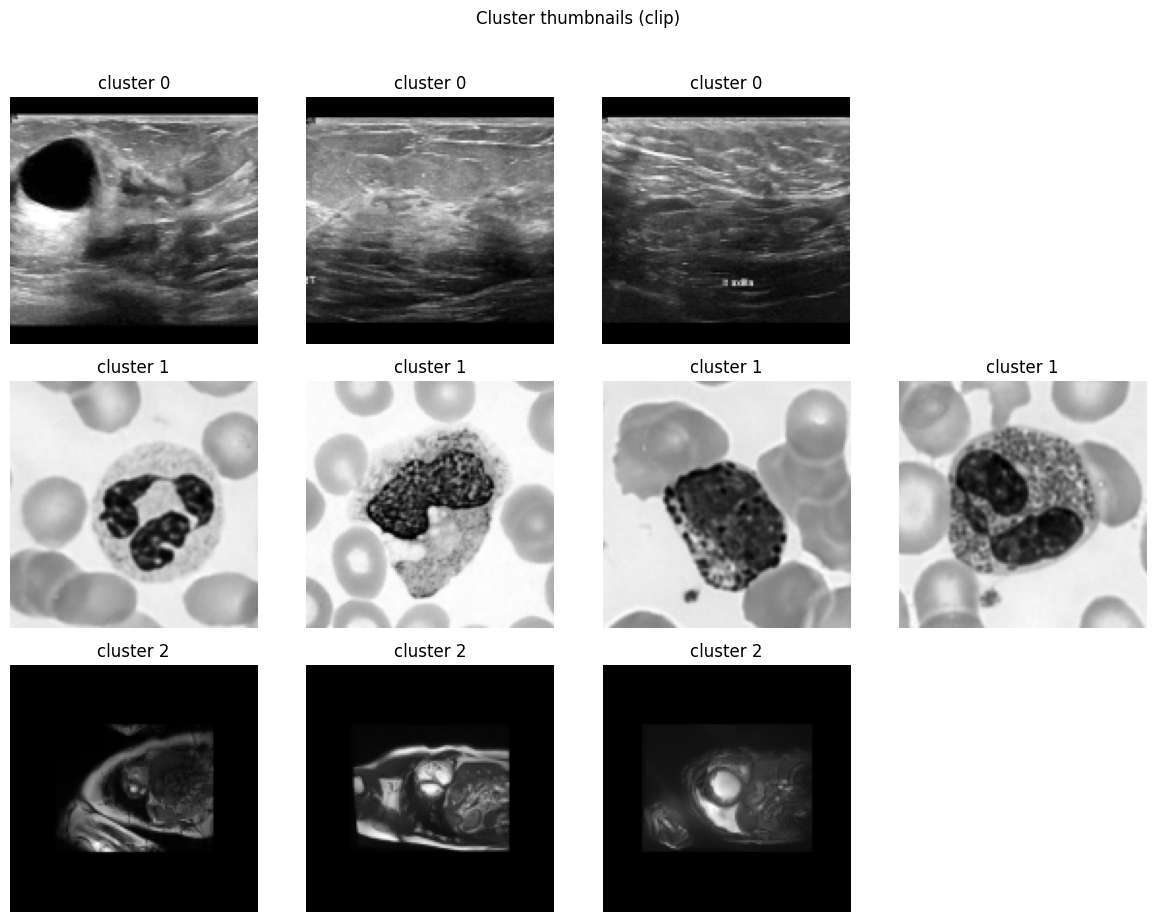

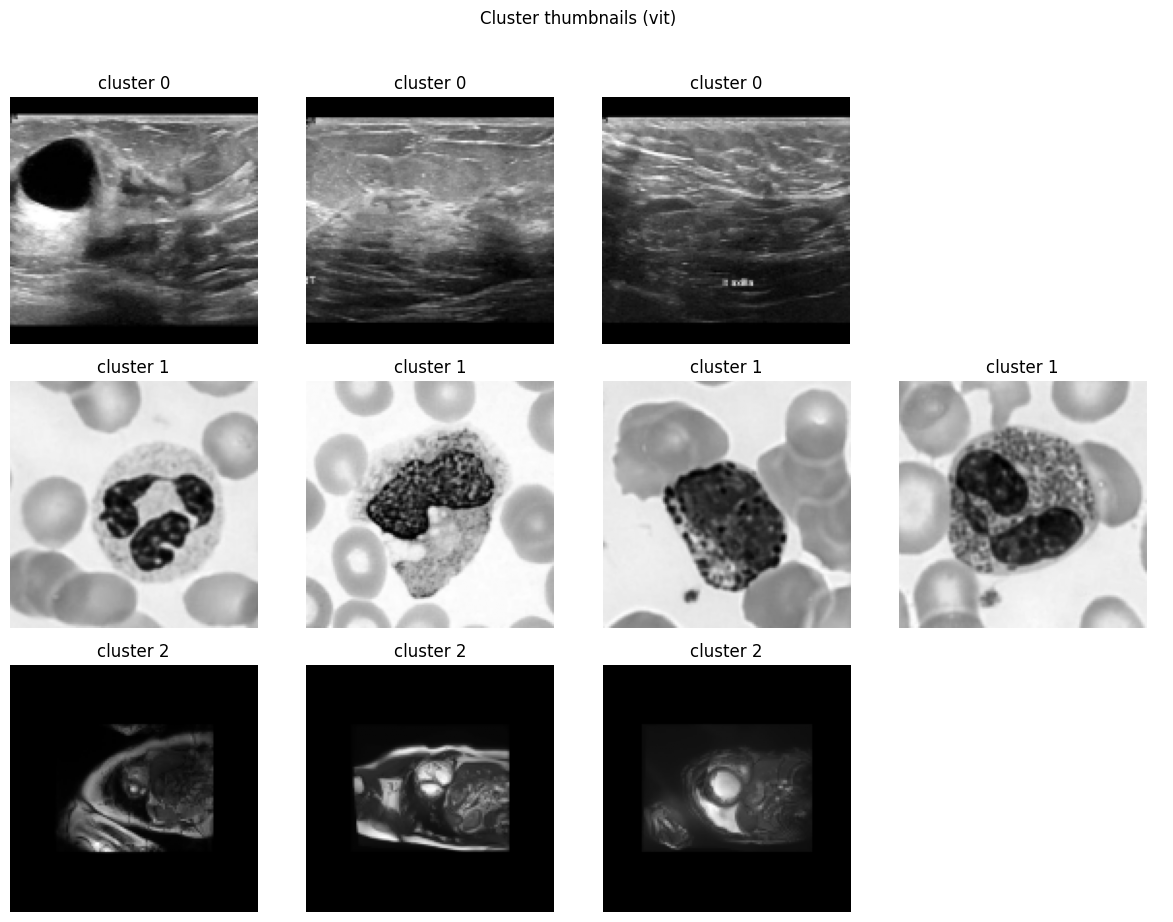

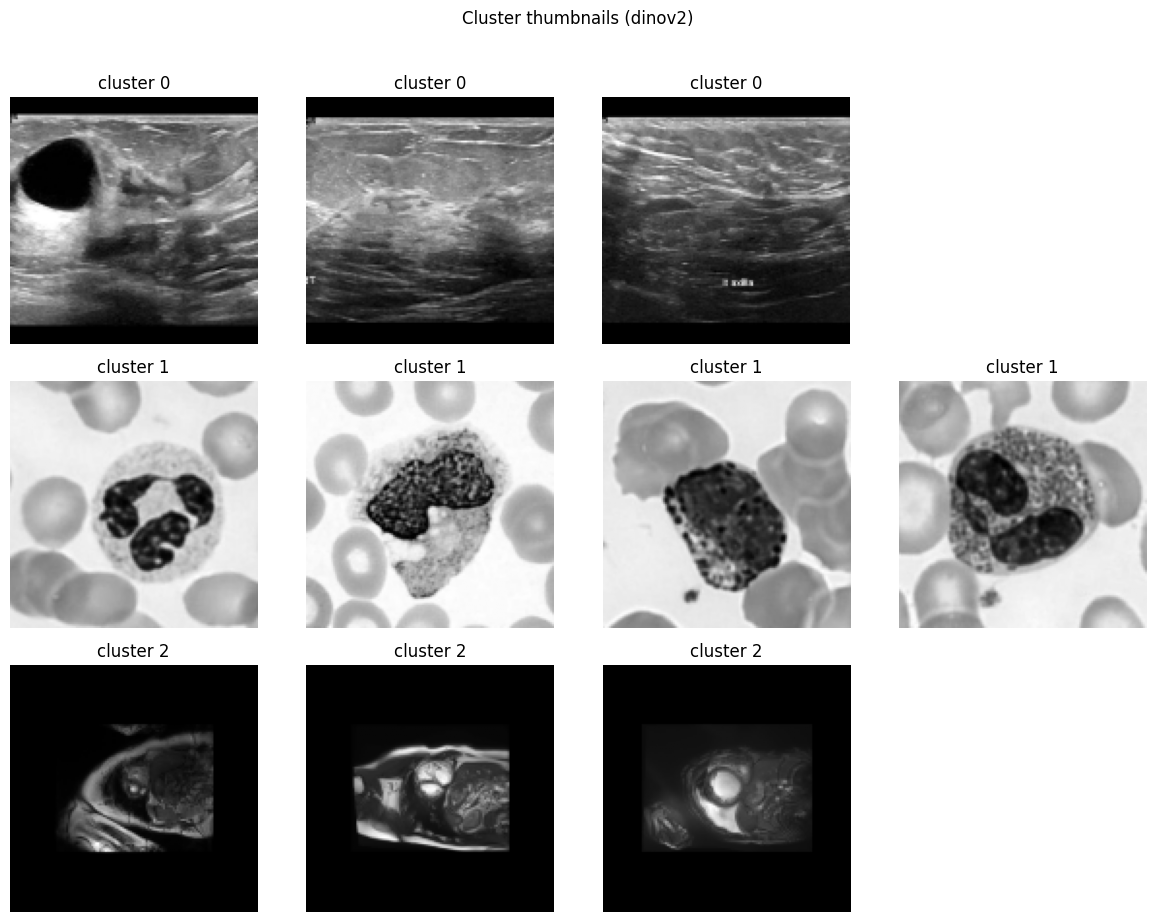

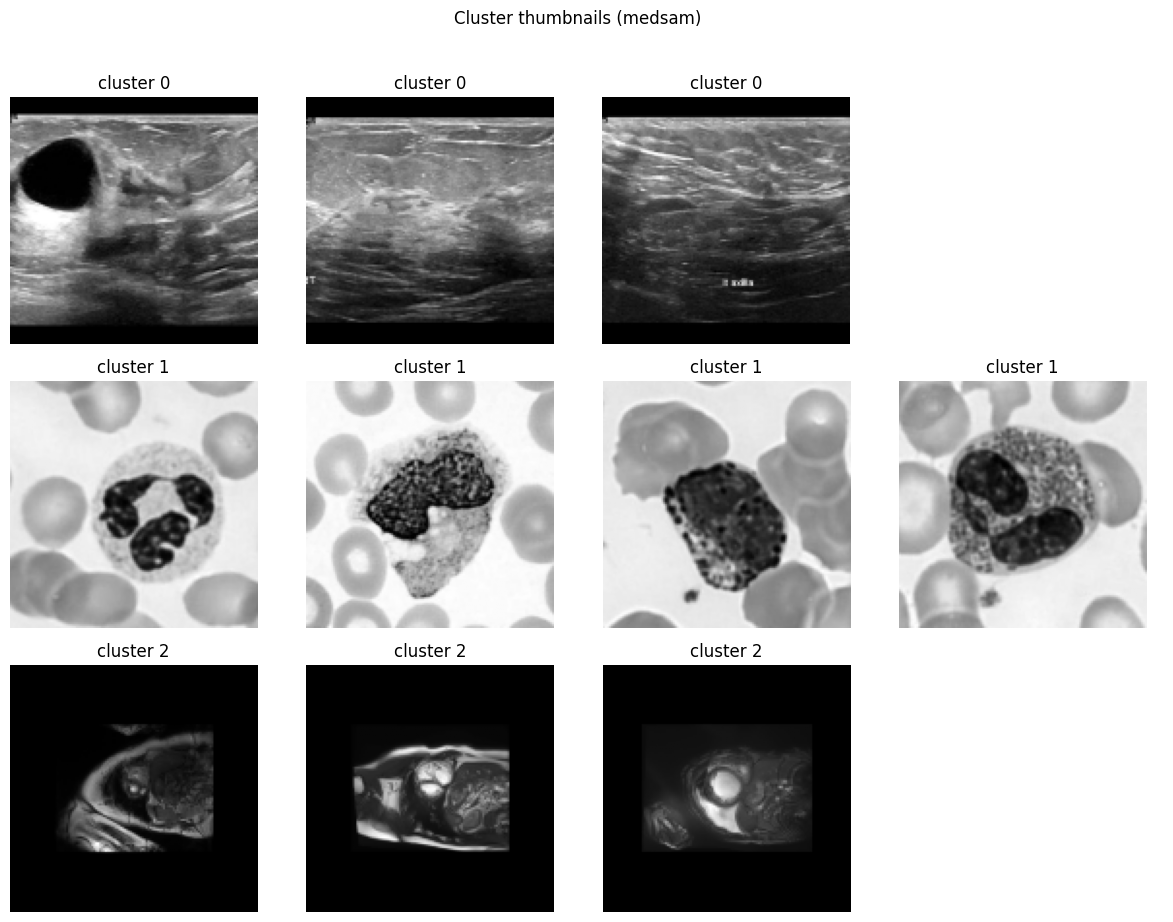

In [8]:
# --- Per-cluster image thumbnails (for each encoder) ---
# Shows all images per cluster.
for encoder_name, emb in embeddings.items():
    pca = PCA(n_components=2, random_state=seed)
    emb2 = pca.fit_transform(emb)
    k = len(set(all_labels))
    km = KMeans(n_clusters=k, random_state=seed, n_init='auto')
    clusters = km.fit_predict(emb2)

    cluster_ids = sorted(set(clusters))
    max_per_cluster = max((clusters == cid).sum() for cid in cluster_ids)
    fig, axes = plt.subplots(len(cluster_ids), max_per_cluster, figsize=(3 * max_per_cluster, 3 * len(cluster_ids)))
    if len(cluster_ids) == 1:
        axes = [axes]
    for row, cid in enumerate(cluster_ids):
        idxs = [i for i, c in enumerate(clusters) if c == cid]
        for col in range(max_per_cluster):
            ax = axes[row][col] if len(cluster_ids) > 1 else axes[col]
            if col < len(idxs):
                img = all_images[idxs[col]].detach().cpu().squeeze().numpy()
                ax.imshow(img, cmap='gray')
                ax.set_title(f"cluster {cid}")
            ax.axis('off')
    fig.suptitle(f'Cluster thumbnails ({encoder_name})', y=1.02)
    fig.tight_layout()
    plt.show()


**Notes**
- Edit `task_specs` to select different tasks/labels/slices.
- If you want more samples, increase `n_samples` per task.
- CLIP/ViT/DINOv2 can be slow on CPU; use GPU if available.
